# 用Kmeans算法计算图像的调色板

In [2]:
%matplotlib inline
import pylab as pl
import numpy as np
import matplotlib

k-平均算法把n个点划分到k个聚类中，使得每个点都属于离他最近的均值对应的聚类，以之作为聚类的标准。下面使用`sklearn.datasets.make_blob()`创建3个聚类，它们的中心分别为`(0, 0), (5, 0), (0, 5)`。

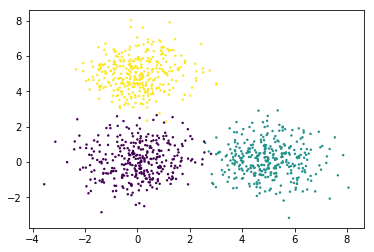

In [3]:
from sklearn.datasets import make_blobs

points, labels = make_blobs(centers=[[0, 0], [5, 0], [0, 5]],
                            n_samples=1000, cluster_std=1.0, random_state=8)
pl.scatter(points[:, 0], points[:, 1], c=labels, s=2);

下面调用`scipy.cluster.vq.kmeans2()`将`points`中的点分为3个聚类。它返回每个聚类的中心和每个点所属的聚类。

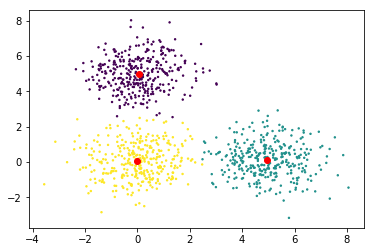

In [7]:
from scipy.cluster import vq

centers, labels = vq.kmeans2(points, 3, iter=20)
pl.scatter(points[:, 0], points[:, 1], c=labels, s=2)
pl.plot(centers[:, 0], centers[:, 1], "ro");

k-平均算法是一种迭代算法，下面的程序调用`kmeans2()`时设置`iter`参数为1，即每次调用进行一次迭代。并将前次计算所得的聚类中心作为下次调用的聚类中心初始值。最后使用`holoviews`显示计算结果。

In [8]:
import holoviews as hv
hv.notebook_extension()

C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


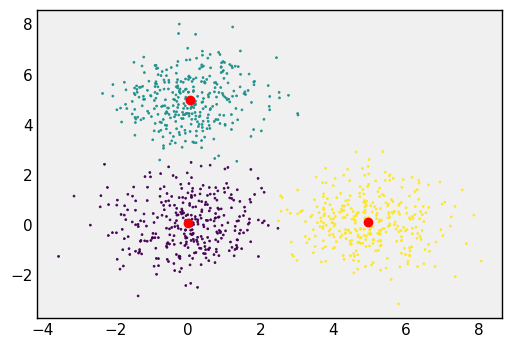

In [9]:
np.random.seed(2)
centers = points[np.random.choice(np.arange(len(points)), 3, replace=False), :]
hm_centers = hv.HoloMap(kdims=["iter"])
hm_labels = hv.HoloMap(kdims=["iter"])
for i in range(1, 11):
    centers, labels = vq.kmeans2(points, centers, iter=1)
    table1 = hv.Table(np.column_stack([centers, np.arange(len(centers))]), kdims=["x", "y", "label"])
    hm_centers[i] = table1.to.scatter(kdims=["x"], vdims=["y"]).overlay()
    table2 = hv.Table(np.column_stack([points, labels]), kdims=["x", "y", "label"])
    hm_labels[i] = table2.to.points(kdims=["x", "y"]).overlay()
    
pl.scatter(points[:, 0], points[:, 1], c=labels, s=2);
pl.plot(centers[:, 0], centers[:, 1], "ro");

b':HoloMap   [iter]\n   :Overlay\n      .NdOverlay.I  :NdOverlay   [label]\n         :Points   [x,y]\n      .NdOverlay.II :NdOverlay   [label]\n         :Scatter   [x]   (y)'
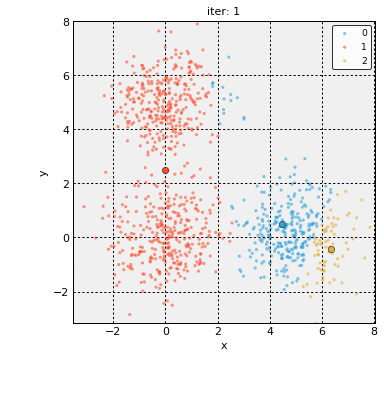
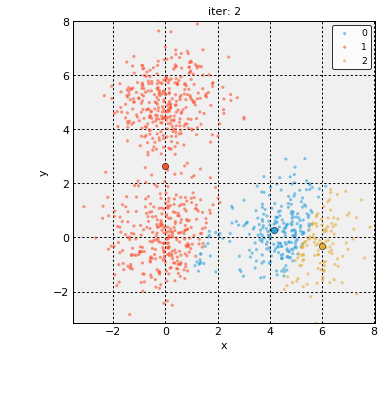
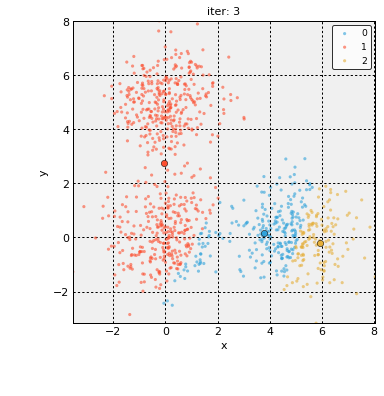
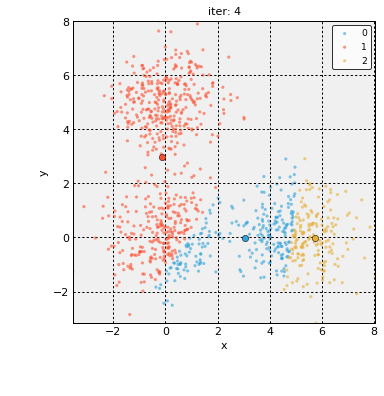
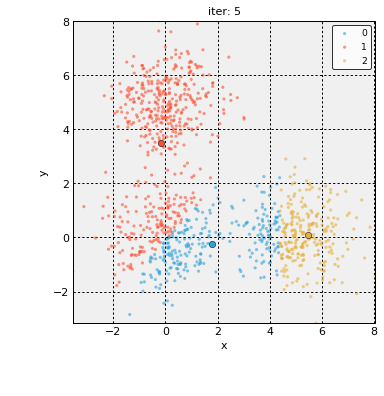
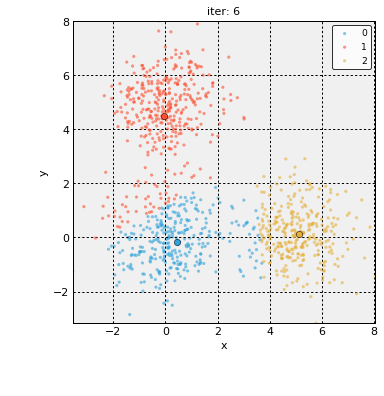
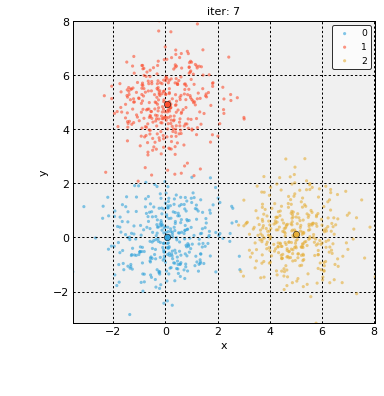
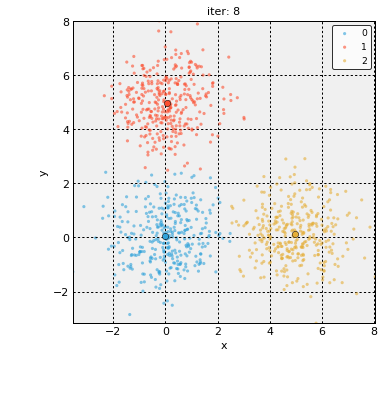
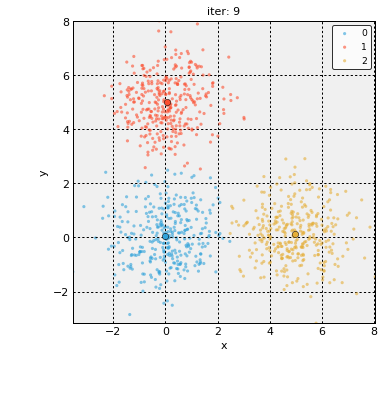
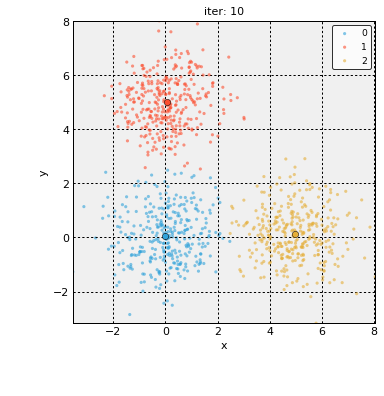

In [10]:
%%opts Overlay [fig_inches=(6, 6)] Points (s=10 alpha=0.6) Scatter (s=40 edgecolor="black")
hm_labels * hm_centers

## 提取图片中的色彩

彩色图像中的每个像素使用红绿蓝三个分量表示，可以将之看作三维空间中的点。使用k-平均算法可以找到该空间中的聚类，即可图像的主要颜色成分。

In [11]:
from PIL import Image

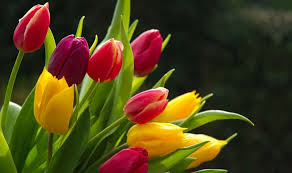

In [12]:
img = Image.open("flower.jpg")
img_arr = np.asarray(img)[:, :, :3]
arr = img_arr.reshape(-1, 3).astype(np.float32)
img

下面计算图像颜色的10个聚类。注意k-平均算法只能收敛于一个局部最优解，因此有可能有些聚类对应的点数为0，此时会出现`One of the clusters is empty`的警告信息。下面的程序使用`numpy.bincount()`统计每个聚类对应的点数，并丢弃点数为0的聚类。

In [23]:
code, labels = vq.kmeans2(arr, 10)
code = code.astype(np.uint8)
colors = code[np.bincount(labels) > 0]

def display_colors(colors):
    from IPython.display import display_html
    colors = colors[np.argsort(colors.sum(1))]
    pattern = '<span style="padding:20px;background-color:#{:02x}{:02x}{:02x}"></span>'
    display_html("".join(pattern.format(*row) for row in colors), raw=True)

display_colors(colors)

C:\Anaconda3\lib\site-packages\scipy\cluster\vq.py:660: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 9
  app.launch_new_instance()


使用`code[labels]`可以得到以聚类中心表示每个点的图像，即只使用7种颜色（有几个聚类的点数为0）表示的图像。

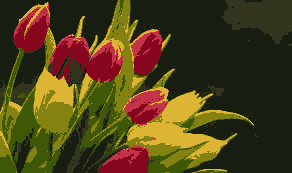

In [25]:
Image.fromarray(code[labels].reshape(img_arr.shape))